

# **A tale of different optimizers on MedMNIST dataset**
## By **Aritra Raut** , **M.Sc. in Big Data Analytics** , **Ramakrishna Mission Vivekananda Education and Research Institute**
### Special thanks to <a href="https://www.mayo.edu/research/labs/radiology-informatics/overview">Dr. Bradley J. Erickson M.D., Ph.D.</a> - Department of Radiology, Mayo Clinic
#### Acknowledgements: <a href="http://www.cancerimagingarchive.net/">The Cancer Imaging Archive (TCIA)</a>; <a href ="http://rsnachallenges.cloudapp.net/competitions/4">Radiological Society of North America</a>; <a href= "http://openaccess.thecvf.com/content_cvpr_2017/papers/Wang_ChestX-ray8_Hospital-Scale_Chest_CVPR_2017_paper.pdf">National Institute of Health</a>


In [1]:
!git clone "https://github.com/apolanco3225/Medical-MNIST-Classification"

Cloning into 'Medical-MNIST-Classification'...
remote: Enumerating objects: 58532, done.
remote: Total 58532 (delta 0), reused 0 (delta 0), pack-reused 58532
Receiving objects: 100% (58532/58532), 77.86 MiB | 31.93 MiB/s, done.
Resolving deltas: 100% (506/506), done.
Checking out files: 100% (58959/58959), done.


In [2]:
cd Medical-MNIST-Classification/

/content/Medical-MNIST-Classification


In [ ]:
!ls

hints.txt  images  MedNIST.ipynb  resized


In [3]:
import numpy as np
import os
import time
%matplotlib inline
import matplotlib.pyplot as mp
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as om
import torchvision as tv
import torch.utils.data as dat

if torch.cuda.is_available():     # Make sure GPU is available
    dev = torch.device("cuda:0")
    kwar = {'num_workers': 8, 'pin_memory': True}
    cpu = torch.device("cpu")
else:
    print("Warning: CUDA not found, CPU only.")
    dev = torch.device("cpu")
    kwar = {}
    cpu = torch.device("cpu")

np.random.seed(551)



## Loading Data and Creating Datasets
Due to cost, privacy restrictions, and the rarity of certain conditions, gathering medical datasets can be particularly challenging. Once gathered from disparate sources, these data will need to be standardized for training. Preparing data at this level is beyond the scope of this short introductory primer. We have gathered images from several sets at TCIA, the RSNA Bone Age Challenge, and the NIH Chest X-ray dataset and standardized them to the same size.

The code below examines our image set, organizes the filenames, and displays some statistics about them.


In [4]:
dataDir = 'resized'               # The main data directory
classNames = os.listdir(dataDir)  # Each type of image can be found in its own subdirectory
numClass = len(classNames)        # Number of types = number of subdirectories
imageFiles = [[os.path.join(dataDir,classNames[i],x) for x in os.listdir(os.path.join(dataDir,classNames[i]))]
              for i in range(numClass)]                     # A nested list of filenames
numEach = [len(imageFiles[i]) for i in range(numClass)]     # A count of each type of image
imageFilesList = []               # Created an un-nested list of filenames
imageClass = []                   # The labels -- the type of each individual image in the list
for i in range(numClass):
    imageFilesList.extend(imageFiles[i])
    imageClass.extend([i]*numEach[i])
numTotal = len(imageClass)        # Total number of images
imageWidth, imageHeight = Image.open(imageFilesList[0]).size         # The dimensions of each image

print("There are",numTotal,"images in",numClass,"distinct categories")
print("Label names:",classNames)
print("Label counts:",numEach)
print("Image dimensions:",imageWidth,"x",imageHeight)

There are 58954 images in 6 distinct categories
Label names: ['ChestCT', 'Hand', 'AbdomenCT', 'BreastMRI', 'CXR', 'HeadCT']
Label counts: [10000, 10000, 10000, 8954, 10000, 10000]
Image dimensions: 64 x 64


Text(0.5, 1.0, 'class distribution')

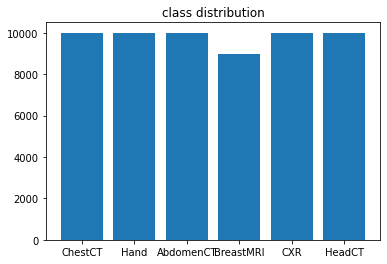

In [5]:
import matplotlib.pyplot as plt

plt.bar(classNames,numEach)
plt.title("class distribution")

Because it is comparable to the <a href="http://yann.lecun.com/exdb/mnist/">MNIST dataset</a>, which has 70,000 total 28 x 28 images of handwritten digits from 0 - 9, we call this the MedNIST dataset. Notice, however, that the data aren't perfectly balanced. We'll address that while training the model.

As the saying goes, a picture is worth 1,000 ± 32 statistics, so let's examine a few random sample images. The following cell can be run repeatedly.
   
### **Few examples of the dataset :::**

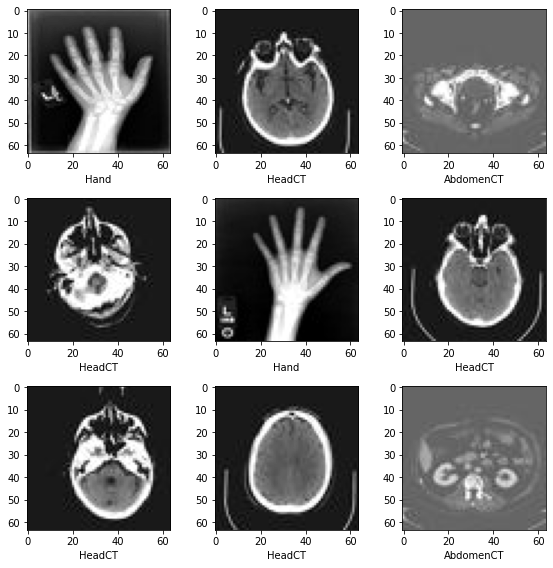

In [6]:
mp.subplots(3,3,figsize=(8,8))
for i,k in enumerate(np.random.randint(numTotal, size=9)):  # Take a random sample of 9 images and
    im = Image.open(imageFilesList[k])                      #      plot and label them
    arr = np.array(im)
    mp.subplot(3,3,i+1)
    mp.xlabel(classNames[imageClass[k]])
    mp.imshow(arr,cmap='gray',vmin=0,vmax=255)
mp.tight_layout()
mp.show()


# **probable use of this dataset  :::**

In most of the cases nowadays the full body CT scan is being done and to check problem in different parts of the body ,the cropped images of the diffrent parts can be sent to the doctors.So to send them with an automated system we need to do perfect classification of them. We have implemented this network to perform it perfectly.

## Transforming Data and Partitioning into Training, Validation, and Testing Sets :::

Depending on the images shown, you may notice a few things. There are definitely higher and lower quality images. Also, some images also have a different scale - the background isn't black but gray. Because there's a smaller difference between pixels, our model might have a harder time extracting information from them. Thus, to increase the contrast, we first rescale every image so the pixel values run from 0 to 1. 

Next, we subtract the mean pixel value of each individual image from the rest. The network could in principle learn to do this through training. However, the activation functions tend to be most sensitive / nonlinear near zero. Therefore, shifting our data to have an average input value of zero will improve the sensitivity and stability of initial training steps and tends to speed things up a little. While it doesn't matter much for the simple model we use here, such tricks can make a noticeable difference in complex models.

Also, before doing any of these, we'll need to convert the JPEG images into tensors. We define a function below that combines all these steps.

In [7]:
toTensor = tv.transforms.ToTensor()
def scaleImage(x):          # Pass a PIL image, return a tensor
    y = toTensor(x)
    if(y.min() < y.max()):  # Assuming the image isn't empty, rescale so its values run from 0 to 1
        y = (y - y.min())/(y.max() - y.min()) 
    z = y - y.mean()        # Subtract the mean value of the image
    return z


With the image-to-tensor transformation function defined, we now create a master tensor out of all these images. We also create a tensor for the labels. Execution of this code takes a moment. We double check the final range of scaled pixel values and verify that the mean is (practically) zero.


In [8]:
imageTensor = torch.stack([scaleImage(Image.open(x)) for x in imageFilesList])  # Load, scale, and stack image (X) tensor
classTensor = torch.tensor(imageClass)  # Create label (Y) tensor
print("Rescaled min pixel value = {:1.3}; Max = {:1.3}; Mean = {:1.3}"
      .format(imageTensor.min().item(),imageTensor.max().item(),imageTensor.mean().item()))


Rescaled min pixel value = -0.786; Max = 0.972; Mean = -3.15e-09


In [9]:
validFrac = 0.1   # Define the fraction of images to move to validation dataset
testFrac = 0.1    # Define the fraction of images to move to test dataset
validList = []
testList = []
trainList = []

for i in range(numTotal):
    rann = np.random.random() # Randomly reassign images
    if rann < validFrac:
        validList.append(i)
    elif rann < testFrac + validFrac:
        testList.append(i)
    else:
        trainList.append(i)
        
nTrain = len(trainList)  # Count the number in each set
nValid = len(validList)
nTest = len(testList)
print("Training images =",nTrain,"Validation =",nValid,"Testing =",nTest)



Training images = 47381 Validation = 5833 Testing = 5740


If we're satisfied with the breakdown into training, validation, and testing, we can now use these lists to slice the master tensors with the code below. If not, we can rerun the cell above with different fractions set aside.


In [10]:
trainIds = torch.tensor(trainList)    # Slice the big image and label tensors up into
validIds = torch.tensor(validList)    #       training, validation, and testing tensors
testIds = torch.tensor(testList)
trainX = imageTensor[trainIds,:,:,:]
trainY = classTensor[trainIds]
validX = imageTensor[validIds,:,:,:]
validY = classTensor[validIds]
testX = imageTensor[testIds,:,:,:]
testY = classTensor[testIds]


## Model Architecture :::




In [11]:
class MedNet(nn.Module):
    def __init__(self,xDim,yDim,numC): # Pass image dimensions and number of labels when initializing a model   
        super(MedNet,self).__init__()  # Extends the basic nn.Module to the MedNet class
        # The parameters here define the architecture of the convolutional portion of the CNN. Each image pixel
        # has numConvs convolutions applied to it, and convSize is the number of surrounding pixels included
        # in each convolution. Lastly, the numNodesToFC formula calculates the final, remaining nodes at the last
        # level of convolutions so that this can be "flattened" and fed into the fully connected layers subsequently.
        # Each convolution makes the image a little smaller (convolutions do not, by default, "hang over" the edges
        # of the image), and this makes the effective image dimension decreases.
        
        numConvs1 = 5
        convSize1 = 7
        numConvs2 = 10
        convSize2 = 7
        numNodesToFC = numConvs2*(xDim-(convSize1-1)-(convSize2-1))*(yDim-(convSize1-1)-(convSize2-1))

        # nn.Conv2d(channels in, channels out, convolution height/width)
        # 1 channel -- grayscale -- feeds into the first convolution. The same number output from one layer must be
        # fed into the next. These variables actually store the weights between layers for the model.
        
        self.cnv1 = nn.Conv2d(1, numConvs1, convSize1)
        self.cnv2 = nn.Conv2d(numConvs1, numConvs2, convSize2)

        # These parameters define the number of output nodes of each fully connected layer.
        # Each layer must output the same number of nodes as the next layer begins with.
        # The final layer must have output nodes equal to the number of labels used.
        
        fcSize1 = 400
        fcSize2 = 80
        
        # nn.Linear(nodes in, nodes out)
        # Stores the weights between the fully connected layers
        
        self.ful1 = nn.Linear(numNodesToFC,fcSize1)
        self.ful2 = nn.Linear(fcSize1, fcSize2)
        self.ful3 = nn.Linear(fcSize2,numC)
        
    def forward(self,x):
        # This defines the steps used in the computation of output from input.
        # It makes uses of the weights defined in the __init__ method.
        # Each assignment of x here is the result of feeding the input up through one layer.
        # Here we use the activation function elu, which is a smoother version of the popular relu function.
        
        x = F.elu(self.cnv1(x)) # Feed through first convolutional layer, then apply activation
        x = F.elu(self.cnv2(x)) # Feed through second convolutional layer, apply activation
        x = x.view(-1,self.num_flat_features(x)) # Flatten convolutional layer into fully connected layer
        x = F.elu(self.ful1(x)) # Feed through first fully connected layer, apply activation
        x = F.elu(self.ful2(x)) # Feed through second FC layer, apply output
        x = self.ful3(x)        # Final FC layer to output. No activation, because it's used to calculate loss
        return x

    def num_flat_features(self, x):  # Count the individual nodes in a layer
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

With the architecture defined, we create an instance of the model. This single line is separated out so that we can continue or repeat the training code below without resetting the model from scratch, if needed.

### Initialization of model 

In [12]:
model = MedNet(imageWidth,imageHeight,numClass).to(dev)

## Training the Model



## **training and results using SGD optimizer**

In [13]:
learnRate = 0.001          # Define a learning rate.
maxEpochs = 20            # Maximum training epochs
t2vRatio = 1.2            # Maximum allowed ratio of validation to training loss
t2vEpochs = 3             # Number of consecutive epochs before halting if validation loss exceeds above limit
batchSize = 300           # Batch size. Going too large will cause an out-of-memory error.
trainBats = nTrain // batchSize       # Number of training batches per epoch. Round down to simplify last batch
validBats = nValid // batchSize       # Validation batches. Round down
testBats = -(-nTest // batchSize)     # Testing batches. Round up to include all
CEweights = torch.zeros(numClass)     # This takes into account the imbalanced dataset.
for i in trainY.tolist():             #      By making rarer images count more to the loss, 
    CEweights[i].add_(1)              #      we prevent the model from ignoring them.
CEweights = 1. / CEweights.clamp_(min=1.)                     # Weights should be inversely related to count
CEweights = (CEweights * numClass / CEweights.sum()).to(dev)  # The weights average to 1
opti = om.SGD(model.parameters(), lr = learnRate)   # Initialize an optimizer

train_loss_list_sgd = []
valid_loss_list_sgd = []

conv1_grad=[]
conv2_grad=[]

for i in range(maxEpochs):
    model.train()                     # Set model to training mode
    epochLoss = 0.
    permute = torch.randperm(nTrain)  # Shuffle data to randomize batches
    trainX = trainX[permute,:,:,:]
    trainY = trainY[permute]
    for j in range(trainBats):        # Iterate over batches
        opti.zero_grad()              # Zero out gradient accumulated in optimizer
        batX = trainX[j*batchSize:(j+1)*batchSize,:,:,:].to(dev)   # Slice shuffled data into batches
        batY = trainY[j*batchSize:(j+1)*batchSize].to(dev)         # .to(dev) moves these batches to the GPU
        yOut = model(batX)            # Evalute predictions
        loss = F.cross_entropy(yOut, batY,weight=CEweights)        # Compute loss
        epochLoss += loss.item()      # Add loss
        loss.backward()               # Backpropagate loss
        opti.step()                   # Update model weights using optimizer
    validLoss = 0.
    permute = torch.randperm(nValid)  # We go through the exact same steps, without backprop / optimization
    validX = validX[permute,:,:,:]    # in order to evaluate the validation loss
    validY = validY[permute]
    model.eval()                      # Set model to evaluation mode
    with torch.no_grad():             # Temporarily turn off gradient descent
        for j in range(validBats):
            #opti.zero_grad()
            batX = validX[j*batchSize:(j+1)*batchSize,:,:,:].to(dev)
            batY = validY[j*batchSize:(j+1)*batchSize].to(dev)
            yOut = model(batX)
            validLoss += F.cross_entropy(yOut, batY,weight=CEweights).item()
    epochLoss /= trainBats            # Average loss over batches and print
    validLoss /= validBats

    train_loss_list_sgd.append(epochLoss)
    valid_loss_list_sgd.append(validLoss)
    print("Epoch = {:-3}; Training loss = {:.4f}; Validation loss = {:.4f}".format(i,epochLoss,validLoss))

    conv1_grad.append(torch.linalg.norm(model.cnv1.weight.grad))
    conv2_grad.append(torch.linalg.norm(model.cnv2.weight.grad))
    print("conv1 grads",torch.linalg.norm(model.cnv1.weight.grad)) 
    print("conv2 grads",torch.linalg.norm(model.cnv2.weight.grad))
    print("\n")
    # if validLoss > t2vRatio * epochLoss:
    #     t2vEpochs -= 1                # Test if validation loss exceeds halting threshold
    #     if t2vEpochs < 1:
    #         print("Validation loss too high; halting to prevent overfitting")
    #         break
    

Epoch =   0; Training loss = 1.7662; Validation loss = 1.7233
conv1 grads tensor(0.3486, device='cuda:0')
conv2 grads tensor(0.3368, device='cuda:0')


Epoch =   1; Training loss = 1.5946; Validation loss = 1.3920
conv1 grads tensor(0.9072, device='cuda:0')
conv2 grads tensor(0.9567, device='cuda:0')


Epoch =   2; Training loss = 1.1016; Validation loss = 0.8294
conv1 grads tensor(0.5769, device='cuda:0')
conv2 grads tensor(0.7683, device='cuda:0')


Epoch =   3; Training loss = 0.6428; Validation loss = 0.5039
conv1 grads tensor(0.4675, device='cuda:0')
conv2 grads tensor(0.5560, device='cuda:0')


Epoch =   4; Training loss = 0.4283; Validation loss = 0.3698
conv1 grads tensor(0.3619, device='cuda:0')
conv2 grads tensor(0.4062, device='cuda:0')


Epoch =   5; Training loss = 0.3322; Validation loss = 0.2994
conv1 grads tensor(0.2157, device='cuda:0')
conv2 grads tensor(0.2959, device='cuda:0')


Epoch =   6; Training loss = 0.2801; Validation loss = 0.2554
conv1 grads tensor(0.1404,

**Results visualization :::**

Text(0, 0.5, 'loss')

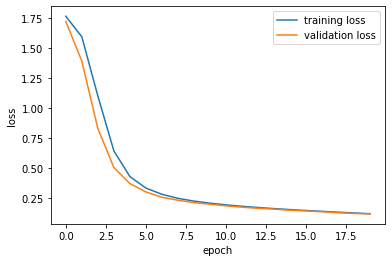

In [14]:
import matplotlib.pyplot as plt
plt.plot(train_loss_list_sgd,label='training loss')
plt.plot(valid_loss_list_sgd,label='validation loss')
plt.legend()
plt.xlabel("epoch")
plt.ylabel("loss")

it's pretty good . the training and validation losses are decreasing in a very good manner. and after 5 epochs the rate of decrease has decreased comparatively.

Text(0.5, 0, 'epoch')

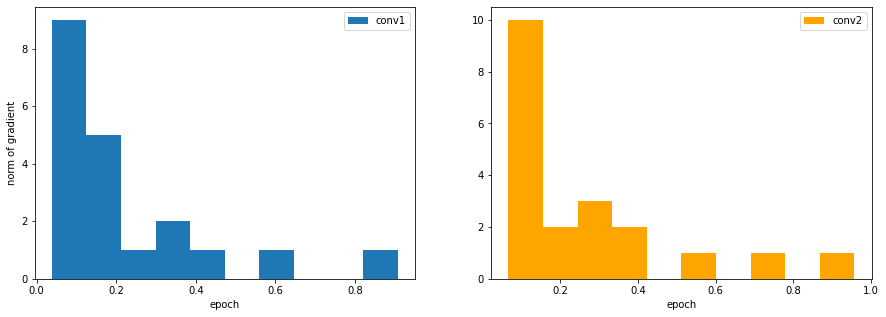

In [15]:
# plt.plot(conv1_grad,label='first layer')
# plt.plot(conv2_grad,label='second layer')
# plt.legend()
cnv1 = []
cnv2 = []
for i in range(len(conv1_grad)):
  cnv1.append(conv1_grad[i].cpu())
  cnv2.append(conv2_grad[i].cpu())

plt.figure(figsize=(15,5))
plt.title("norm of the gradients")

plt.subplot(121)
plt.hist(cnv1,label='conv1')
plt.legend()
plt.xlabel("epoch")
plt.ylabel("norm of gradient")

plt.subplot(122)
plt.hist(cnv2,label='conv2',color='orange')
plt.legend()
plt.xlabel("epoch")
#plt.ylabel("norm of gradient")

Above is the histogram plots of the norm of the gradients of the two convolution layer and as our expectations the histogram beans are heavy near zero. So, we should be happy with this outcomes. Now let's take a look at the accuracy it is achieving.

In [18]:
confuseMtx = np.zeros((numClass,numClass),dtype=int)    # Create empty confusion matrix
model.eval()
with torch.no_grad():
    permute = torch.randperm(nTest)                     # Shuffle test data
    testX = testX[permute,:,:,:]
    testY = testY[permute]
    for j in range(testBats):                           # Iterate over test batches
        batX = testX[j*batchSize:(j+1)*batchSize,:,:,:].to(dev)
        batY = testY[j*batchSize:(j+1)*batchSize].to(dev)
        yOut = model(batX)                              # Pass test batch through model
        pred = yOut.max(1,keepdim=True)[1]              # Generate predictions by finding the max Y values
        for j in torch.cat((batY.view_as(pred), pred),dim=1).tolist(): # Glue together Actual and Predicted to
            confuseMtx[j[0],j[1]] += 1                  # make (row, col) pairs, and increment confusion matrix
correct = sum([confuseMtx[i,i] for i in range(numClass)])   # Sum over diagonal elements to count correct predictions
print("Correct predictions: ",correct,"of",nTest)
print("Accuracy :",(correct/nTest)*100 ,"%")
print("Confusion Matrix:")
print(confuseMtx)
print(classNames)


Correct predictions:  5526 of 5740
Accuracy : 96.27177700348432 %
Confusion Matrix:
[[926   0  33  10   0   3]
 [  0 981   1   1   3  17]
 [ 54   0 924   3   0   4]
 [  7   0   4 854   0   0]
 [  1  13   0   0 924   1]
 [ 41   5  11   0   2 917]]
['ChestCT', 'Hand', 'AbdomenCT', 'BreastMRI', 'CXR', 'HeadCT']


OH damn !!! accuracy is pretty much high. But, let's see if we can do it more accurate.

## **Training with SGD momentum :::**
With the simple gradient we introduce a momentum term now , which is basically keeping the essence of the previous gradients.  

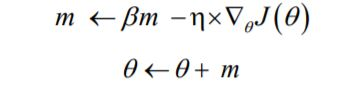

In [21]:
model = MedNet(imageWidth,imageHeight,numClass).to(dev)
learnRate = 0.001          # Define a learning rate.
maxEpochs = 20            # Maximum training epochs
t2vRatio = 1.2            # Maximum allowed ratio of validation to training loss
t2vEpochs = 3             # Number of consecutive epochs before halting if validation loss exceeds above limit
batchSize = 300           # Batch size. Going too large will cause an out-of-memory error.
trainBats = nTrain // batchSize       # Number of training batches per epoch. Round down to simplify last batch
validBats = nValid // batchSize       # Validation batches. Round down
testBats = -(-nTest // batchSize)     # Testing batches. Round up to include all
CEweights = torch.zeros(numClass)     # This takes into account the imbalanced dataset.
for i in trainY.tolist():             #      By making rarer images count more to the loss, 
    CEweights[i].add_(1)              #      we prevent the model from ignoring them.
CEweights = 1. / CEweights.clamp_(min=1.)                     # Weights should be inversely related to count
CEweights = (CEweights * numClass / CEweights.sum()).to(dev)  # The weights average to 1
opti = om.SGD(model.parameters(), lr = learnRate, momentum = 0.3)   # Initialize an optimizer

train_loss_list_sgd_momentum = []
valid_loss_list_sgd_momentum = []

conv1_grad_sgd_momentum=[]
conv2_grad_sgd_momentum=[]

for i in range(maxEpochs):
    model.train()                     # Set model to training mode
    epochLoss = 0.
    permute = torch.randperm(nTrain)  # Shuffle data to randomize batches
    trainX = trainX[permute,:,:,:]
    trainY = trainY[permute]
    for j in range(trainBats):        # Iterate over batches
        opti.zero_grad()              # Zero out gradient accumulated in optimizer
        batX = trainX[j*batchSize:(j+1)*batchSize,:,:,:].to(dev)   # Slice shuffled data into batches
        batY = trainY[j*batchSize:(j+1)*batchSize].to(dev)         # .to(dev) moves these batches to the GPU
        yOut = model(batX)            # Evalute predictions
        loss = F.cross_entropy(yOut, batY,weight=CEweights)        # Compute loss
        epochLoss += loss.item()      # Add loss
        loss.backward()               # Backpropagate loss
        opti.step()                   # Update model weights using optimizer
    validLoss = 0.
    permute = torch.randperm(nValid)  # We go through the exact same steps, without backprop / optimization
    validX = validX[permute,:,:,:]    # in order to evaluate the validation loss
    validY = validY[permute]
    model.eval()                      # Set model to evaluation mode
    with torch.no_grad():             # Temporarily turn off gradient descent
        for j in range(validBats):
            #opti.zero_grad()
            batX = validX[j*batchSize:(j+1)*batchSize,:,:,:].to(dev)
            batY = validY[j*batchSize:(j+1)*batchSize].to(dev)
            yOut = model(batX)
            validLoss += F.cross_entropy(yOut, batY,weight=CEweights).item()
    epochLoss /= trainBats            # Average loss over batches and print
    validLoss /= validBats

    train_loss_list_sgd_momentum.append(epochLoss)
    valid_loss_list_sgd_momentum.append(validLoss)
    print("Epoch = {:-3}; Training loss = {:.4f}; Validation loss = {:.4f}".format(i,epochLoss,validLoss))

    conv1_grad_sgd_momentum.append(torch.linalg.norm(model.cnv1.weight.grad))
    conv2_grad_sgd_momentum.append(torch.linalg.norm(model.cnv2.weight.grad))
    print("conv1 grads",torch.linalg.norm(model.cnv1.weight.grad)) 
    print("conv2 grads",torch.linalg.norm(model.cnv2.weight.grad))
    print("\n")
    # if validLoss > t2vRatio * epochLoss:
    #     t2vEpochs -= 1                # Test if validation loss exceeds halting threshold
    #     if t2vEpochs < 1:
    #         print("Validation loss too high; halting to prevent overfitting")
    #         break
    

Epoch =   0; Training loss = 1.5129; Validation loss = 1.1277
conv1 grads tensor(0.6761, device='cuda:0')
conv2 grads tensor(0.8705, device='cuda:0')


Epoch =   1; Training loss = 0.7877; Validation loss = 0.5405
conv1 grads tensor(0.4132, device='cuda:0')
conv2 grads tensor(0.5377, device='cuda:0')


Epoch =   2; Training loss = 0.4231; Validation loss = 0.3383
conv1 grads tensor(0.2230, device='cuda:0')
conv2 grads tensor(0.2846, device='cuda:0')


Epoch =   3; Training loss = 0.2988; Validation loss = 0.2606
conv1 grads tensor(0.1650, device='cuda:0')
conv2 grads tensor(0.1909, device='cuda:0')


Epoch =   4; Training loss = 0.2426; Validation loss = 0.2222
conv1 grads tensor(0.1712, device='cuda:0')
conv2 grads tensor(0.1572, device='cuda:0')


Epoch =   5; Training loss = 0.2105; Validation loss = 0.1977
conv1 grads tensor(0.0178, device='cuda:0')
conv2 grads tensor(0.1043, device='cuda:0')


Epoch =   6; Training loss = 0.1897; Validation loss = 0.1792
conv1 grads tensor(0.0897,

Text(0, 0.5, 'loss')

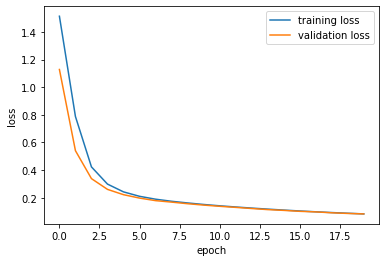

In [22]:
import matplotlib.pyplot as plt
plt.plot(train_loss_list_sgd_momentum,label='training loss')
plt.plot(valid_loss_list_sgd_momentum,label='validation loss')
plt.legend()
plt.xlabel("epoch")
plt.ylabel("loss")

the rate of decrease became slower after 5th epoch like the previous one but if we take a look into the training and validation loss, we can see the improvement. Both the losses are way lesser than the previous one.

Text(0.5, 0, 'epoch')

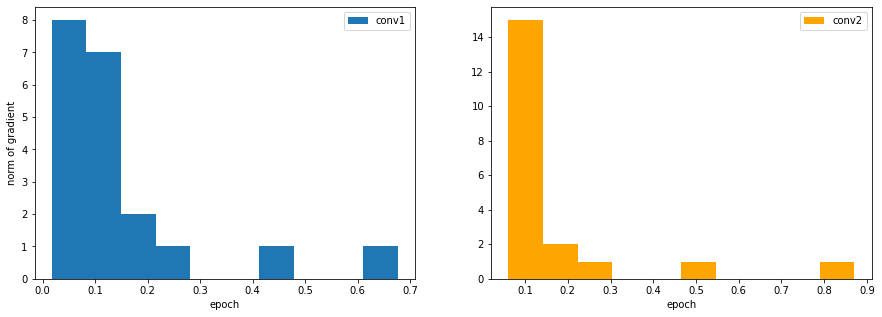

In [23]:
# plt.plot(conv1_grad,label='first layer')
# plt.plot(conv2_grad,label='second layer')
# plt.legend()
cnv1 = []
cnv2 = []
for i in range(len(conv1_grad)):
  cnv1.append(conv1_grad_sgd_momentum[i].cpu())
  cnv2.append(conv2_grad_sgd_momentum[i].cpu())

plt.figure(figsize=(15,5))
plt.title("norm of the gradients")

plt.subplot(121)
plt.hist(cnv1,label='conv1')
plt.legend()
plt.xlabel("epoch")
plt.ylabel("norm of gradient")

plt.subplot(122)
plt.hist(cnv2,label='conv2',color='orange')
plt.legend()
plt.xlabel("epoch")
#plt.ylabel("norm of gradient")

And also in case of reaching the optima at every epoch the performance has improved. the beans near zero are havier than the previous case. So, we can expect a better accuracy from this model. Let's see -

In [24]:
confuseMtx = np.zeros((numClass,numClass),dtype=int)    # Create empty confusion matrix
model.eval()
with torch.no_grad():
    permute = torch.randperm(nTest)                     # Shuffle test data
    testX = testX[permute,:,:,:]
    testY = testY[permute]
    for j in range(testBats):                           # Iterate over test batches
        batX = testX[j*batchSize:(j+1)*batchSize,:,:,:].to(dev)
        batY = testY[j*batchSize:(j+1)*batchSize].to(dev)
        yOut = model(batX)                              # Pass test batch through model
        pred = yOut.max(1,keepdim=True)[1]              # Generate predictions by finding the max Y values
        for j in torch.cat((batY.view_as(pred), pred),dim=1).tolist(): # Glue together Actual and Predicted to
            confuseMtx[j[0],j[1]] += 1                  # make (row, col) pairs, and increment confusion matrix
correct = sum([confuseMtx[i,i] for i in range(numClass)])   # Sum over diagonal elements to count correct predictions
print("Correct predictions: ",correct,"of",nTest)
print("Accuracy :",(correct/nTest)*100," %")
print("Confusion Matrix:")
print(confuseMtx)
print(classNames)


Correct predictions:  5577 of 5740
Accuracy : 97.1602787456446  %
Confusion Matrix:
[[936   0  26   8   0   2]
 [  0 990   1   0   2  10]
 [ 38   0 938   6   0   3]
 [  8   0   1 856   0   0]
 [  0   9   0   0 929   1]
 [ 33   1  13   0   1 928]]
['ChestCT', 'Hand', 'AbdomenCT', 'BreastMRI', 'CXR', 'HeadCT']


YES!!!! as expected we are able to increase the accuracy of the model .

Another important parameter is the **step length** we are taking. If we can can adopt it then may be the process will be much faster.
So , let's check, if we can do it more faster with adopted step lengths !!!

## **Training using Adagrad :::**

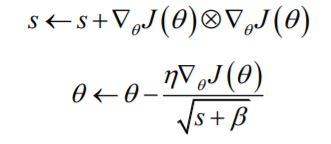

It is clear from the update rule that history of the gradient is accumulated in s . The smaller the gradient accumulated, the smaller the s value will be, leading to a bigger learning rate (because s divides η). So, if we have sparsity present along any direction(representing any of the parameters), the previous algorithms were not taking any update along that direction. But this update rule will provide them a higher learning rate and will decay the learning rate along the non sperse direction over time. 

**Initial learning rate = 0.001**

In [32]:
model = MedNet(imageWidth,imageHeight,numClass).to(dev)
learnRate = 0.001          # Define a learning rate.
maxEpochs = 20            # Maximum training epochs
t2vRatio = 1.2            # Maximum allowed ratio of validation to training loss
t2vEpochs = 3             # Number of consecutive epochs before halting if validation loss exceeds above limit
batchSize = 300           # Batch size. Going too large will cause an out-of-memory error.
trainBats = nTrain // batchSize       # Number of training batches per epoch. Round down to simplify last batch
validBats = nValid // batchSize       # Validation batches. Round down
testBats = -(-nTest // batchSize)     # Testing batches. Round up to include all
CEweights = torch.zeros(numClass)     # This takes into account the imbalanced dataset.
for i in trainY.tolist():             #      By making rarer images count more to the loss, 
    CEweights[i].add_(1)              #      we prevent the model from ignoring them.
CEweights = 1. / CEweights.clamp_(min=1.)                     # Weights should be inversely related to count
CEweights = (CEweights * numClass / CEweights.sum()).to(dev)  # The weights average to 1
opti = om.Adagrad(model.parameters(), lr = learnRate)   # Initialize an optimizer

train_loss_list_adagrad = []
valid_loss_list_adagrad = []

conv1_grad_adagrad=[]
conv2_grad_adagrad=[]

for i in range(maxEpochs):
    model.train()                     # Set model to training mode
    epochLoss = 0.
    permute = torch.randperm(nTrain)  # Shuffle data to randomize batches
    trainX = trainX[permute,:,:,:]
    trainY = trainY[permute]
    for j in range(trainBats):        # Iterate over batches
        opti.zero_grad()              # Zero out gradient accumulated in optimizer
        batX = trainX[j*batchSize:(j+1)*batchSize,:,:,:].to(dev)   # Slice shuffled data into batches
        batY = trainY[j*batchSize:(j+1)*batchSize].to(dev)         # .to(dev) moves these batches to the GPU
        yOut = model(batX)            # Evalute predictions
        loss = F.cross_entropy(yOut, batY,weight=CEweights)        # Compute loss
        epochLoss += loss.item()      # Add loss
        loss.backward()               # Backpropagate loss
        opti.step()                   # Update model weights using optimizer
    validLoss = 0.
    permute = torch.randperm(nValid)  # We go through the exact same steps, without backprop / optimization
    validX = validX[permute,:,:,:]    # in order to evaluate the validation loss
    validY = validY[permute]
    model.eval()                      # Set model to evaluation mode
    with torch.no_grad():             # Temporarily turn off gradient descent
        for j in range(validBats):
            #opti.zero_grad()
            batX = validX[j*batchSize:(j+1)*batchSize,:,:,:].to(dev)
            batY = validY[j*batchSize:(j+1)*batchSize].to(dev)
            yOut = model(batX)
            validLoss += F.cross_entropy(yOut, batY,weight=CEweights).item()
    epochLoss /= trainBats            # Average loss over batches and print
    validLoss /= validBats

    train_loss_list_adagrad.append(epochLoss)
    valid_loss_list_adagrad.append(validLoss)
    print("Epoch = {:-3}; Training loss = {:.4f}; Validation loss = {:.4f}".format(i,epochLoss,validLoss))

    conv1_grad_adagrad.append(torch.linalg.norm(model.cnv1.weight.grad))
    conv2_grad_adagrad.append(torch.linalg.norm(model.cnv2.weight.grad))
    print("conv1 grads",torch.linalg.norm(model.cnv1.weight.grad)) 
    print("conv2 grads",torch.linalg.norm(model.cnv2.weight.grad))
    print("\n")
    # if validLoss > t2vRatio * epochLoss:
    #     t2vEpochs -= 1                # Test if validation loss exceeds halting threshold
    #     if t2vEpochs < 1:
    #         print("Validation loss too high; halting to prevent overfitting")
    #         break
    

Epoch =   0; Training loss = 0.1759; Validation loss = 0.0792
conv1 grads tensor(0.2052, device='cuda:0')
conv2 grads tensor(0.1959, device='cuda:0')


Epoch =   1; Training loss = 0.0507; Validation loss = 0.0375
conv1 grads tensor(0.1424, device='cuda:0')
conv2 grads tensor(0.1348, device='cuda:0')


Epoch =   2; Training loss = 0.0291; Validation loss = 0.0239
conv1 grads tensor(0.0592, device='cuda:0')
conv2 grads tensor(0.0962, device='cuda:0')


Epoch =   3; Training loss = 0.0195; Validation loss = 0.0184
conv1 grads tensor(0.0984, device='cuda:0')
conv2 grads tensor(0.1185, device='cuda:0')


Epoch =   4; Training loss = 0.0140; Validation loss = 0.0169
conv1 grads tensor(0.0543, device='cuda:0')
conv2 grads tensor(0.1612, device='cuda:0')


Epoch =   5; Training loss = 0.0107; Validation loss = 0.0117
conv1 grads tensor(0.1017, device='cuda:0')
conv2 grads tensor(0.1527, device='cuda:0')


Epoch =   6; Training loss = 0.0085; Validation loss = 0.0111
conv1 grads tensor(0.0294,

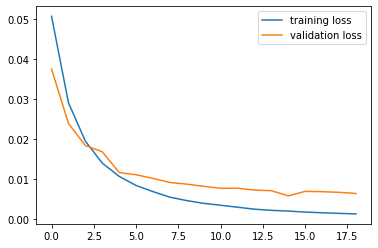

In [33]:
import matplotlib.pyplot as plt
plt.plot(train_loss_list_adagrad[1:],label='training loss')
plt.plot(valid_loss_list_adagrad[1:],label='validation loss')
plt.legend()

Text(0.5, 0, 'epoch')

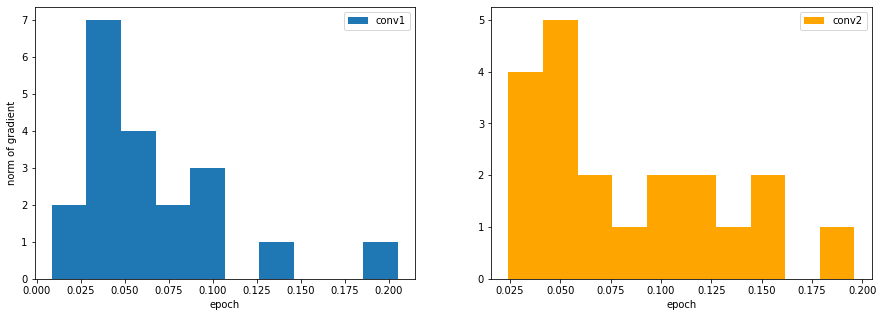

In [34]:
# plt.plot(conv1_grad,label='first layer')
# plt.plot(conv2_grad,label='second layer')
# plt.legend()
cnv1 = []
cnv2 = []
for i in range(len(conv1_grad_adagrad)):
  cnv1.append(conv1_grad_adagrad[i].cpu())
  cnv2.append(conv2_grad_adagrad[i].cpu())

plt.figure(figsize=(15,5))
plt.title("norm of the gradients")

plt.subplot(121)
plt.hist(cnv1,label='conv1')
plt.legend()
plt.xlabel("epoch")
plt.ylabel("norm of gradient")

plt.subplot(122)
plt.hist(cnv2,label='conv2',color='orange')
plt.legend()
plt.xlabel("epoch")
#plt.ylabel("norm of gradient")

oh great !!! the loss is the lowest among the previous models we have shown, and in all of the cases the norm of the gradients are very near to zero . It shows that we got our best model till now.

In [36]:
confuseMtx = np.zeros((numClass,numClass),dtype=int)    # Create empty confusion matrix
model.eval()
with torch.no_grad():
    permute = torch.randperm(nTest)                     # Shuffle test data
    testX = testX[permute,:,:,:]
    testY = testY[permute]
    for j in range(testBats):                           # Iterate over test batches
        batX = testX[j*batchSize:(j+1)*batchSize,:,:,:].to(dev)
        batY = testY[j*batchSize:(j+1)*batchSize].to(dev)
        yOut = model(batX)                              # Pass test batch through model
        pred = yOut.max(1,keepdim=True)[1]              # Generate predictions by finding the max Y values
        for j in torch.cat((batY.view_as(pred), pred),dim=1).tolist(): # Glue together Actual and Predicted to
            confuseMtx[j[0],j[1]] += 1                  # make (row, col) pairs, and increment confusion matrix
correct = sum([confuseMtx[i,i] for i in range(numClass)])   # Sum over diagonal elements to count correct predictions
print("Correct predictions: ",correct,"of",nTest)
print("accuracy :",(correct/nTest)*100," %")
print("Confusion Matrix:")
print(confuseMtx)
print(classNames)


Correct predictions:  5726 of 5740
accuracy : 99.7560975609756  %
Confusion Matrix:
[[970   0   1   1   0   0]
 [  0 999   0   0   3   1]
 [  3   0 982   0   0   0]
 [  0   0   0 865   0   0]
 [  0   3   0   0 936   0]
 [  0   0   2   0   0 974]]
['ChestCT', 'Hand', 'AbdomenCT', 'BreastMRI', 'CXR', 'HeadCT']


It's truely our best model till now in every aspect. But still we couldn't converge in less than 5 epochs. Let's see if we change the directions with momentum in addition to this adopted step length, what happens !!!

## **Training using RMSprop :::**
AdaGrad decays the learning rate very aggressively (as the denominator grows). As a result, after a while, the frequent parameters will start receiving very small updates because of the decayed learning rate. To avoid this we can prevent the denominator's rapid growth by taking a convex combination of the present and history gradients.
And that's the basic intuition behind this RMSProp algorithm.
And here we will be giving more weight to the present gradient at every update.

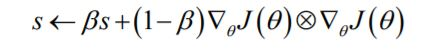

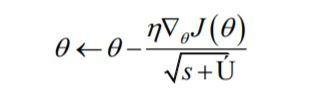

**learning rate = 0.001**

In [44]:
model = MedNet(imageWidth,imageHeight,numClass).to(dev)
learnRate = 0.001          # Define a learning rate.
maxEpochs = 20            # Maximum training epochs
t2vRatio = 1.2            # Maximum allowed ratio of validation to training loss
t2vEpochs = 3             # Number of consecutive epochs before halting if validation loss exceeds above limit
batchSize = 300           # Batch size. Going too large will cause an out-of-memory error.
trainBats = nTrain // batchSize       # Number of training batches per epoch. Round down to simplify last batch
validBats = nValid // batchSize       # Validation batches. Round down
testBats = -(-nTest // batchSize)     # Testing batches. Round up to include all
CEweights = torch.zeros(numClass)     # This takes into account the imbalanced dataset.
for i in trainY.tolist():             #      By making rarer images count more to the loss, 
    CEweights[i].add_(1)              #      we prevent the model from ignoring them.
CEweights = 1. / CEweights.clamp_(min=1.)                     # Weights should be inversely related to count
CEweights = (CEweights * numClass / CEweights.sum()).to(dev)  # The weights average to 1
opti = om.RMSprop(model.parameters(), lr = learnRate,momentum = 0.4)   # Initialize an optimizer
train_loss_list_rmsprop = []
valid_loss_list_rmsprop = []

conv1_grad_rmsprop=[]
conv2_grad_rmsprop=[]

for i in range(maxEpochs):
    model.train()                     # Set model to training mode
    epochLoss = 0.
    permute = torch.randperm(nTrain)  # Shuffle data to randomize batches
    trainX = trainX[permute,:,:,:]
    trainY = trainY[permute]
    for j in range(trainBats):        # Iterate over batches
        opti.zero_grad()              # Zero out gradient accumulated in optimizer
        batX = trainX[j*batchSize:(j+1)*batchSize,:,:,:].to(dev)   # Slice shuffled data into batches
        batY = trainY[j*batchSize:(j+1)*batchSize].to(dev)         # .to(dev) moves these batches to the GPU
        yOut = model(batX)            # Evalute predictions
        loss = F.cross_entropy(yOut, batY,weight=CEweights)        # Compute loss
        epochLoss += loss.item()      # Add loss
        loss.backward()               # Backpropagate loss
        opti.step()                   # Update model weights using optimizer
    validLoss = 0.
    permute = torch.randperm(nValid)  # We go through the exact same steps, without backprop / optimization
    validX = validX[permute,:,:,:]    # in order to evaluate the validation loss
    validY = validY[permute]
    model.eval()                      # Set model to evaluation mode
    with torch.no_grad():             # Temporarily turn off gradient descent
        for j in range(validBats):
            #opti.zero_grad()
            batX = validX[j*batchSize:(j+1)*batchSize,:,:,:].to(dev)
            batY = validY[j*batchSize:(j+1)*batchSize].to(dev)
            yOut = model(batX)
            validLoss += F.cross_entropy(yOut, batY,weight=CEweights).item()
    epochLoss /= trainBats            # Average loss over batches and print
    validLoss /= validBats

    train_loss_list_rmsprop.append(epochLoss)
    valid_loss_list_rmsprop.append(validLoss)
    print("Epoch = {:-3}; Training loss = {:.4f}; Validation loss = {:.4f}".format(i,epochLoss,validLoss))

    conv1_grad_rmsprop.append(torch.linalg.norm(model.cnv1.weight.grad))
    conv2_grad_rmsprop.append(torch.linalg.norm(model.cnv2.weight.grad))
    print("conv1 grads",torch.linalg.norm(model.cnv1.weight.grad)) 
    print("conv2 grads",torch.linalg.norm(model.cnv2.weight.grad))
    print("\n")
    # if validLoss > t2vRatio * epochLoss:
    #     t2vEpochs -= 1                # Test if validation loss exceeds halting threshold
    #     if t2vEpochs < 1:
    #         print("Validation loss too high; halting to prevent overfitting")
    #         break
    

Epoch =   0; Training loss = 1.2765; Validation loss = 0.0353
conv1 grads tensor(0.3869, device='cuda:0')
conv2 grads tensor(0.3286, device='cuda:0')


Epoch =   1; Training loss = 0.0240; Validation loss = 0.0142
conv1 grads tensor(0.0464, device='cuda:0')
conv2 grads tensor(0.0310, device='cuda:0')


Epoch =   2; Training loss = 0.0252; Validation loss = 0.0121
conv1 grads tensor(0.0692, device='cuda:0')
conv2 grads tensor(0.0568, device='cuda:0')


Epoch =   3; Training loss = 0.2128; Validation loss = 0.1136
conv1 grads tensor(0.6931, device='cuda:0')
conv2 grads tensor(0.5456, device='cuda:0')


Epoch =   4; Training loss = 0.0293; Validation loss = 0.0118
conv1 grads tensor(0.3051, device='cuda:0')
conv2 grads tensor(0.1852, device='cuda:0')


Epoch =   5; Training loss = 0.0077; Validation loss = 0.0069
conv1 grads tensor(0.1393, device='cuda:0')
conv2 grads tensor(0.1373, device='cuda:0')


Epoch =   6; Training loss = 0.0474; Validation loss = 0.0177
conv1 grads tensor(0.0134,

**results :**

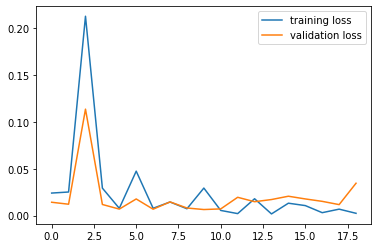

In [45]:
import matplotlib.pyplot as plt
plt.plot(train_loss_list_rmsprop[1:],label='training loss')
plt.plot(valid_loss_list_rmsprop[1:],label='validation loss')
plt.legend()


Text(0.5, 0, 'epoch')

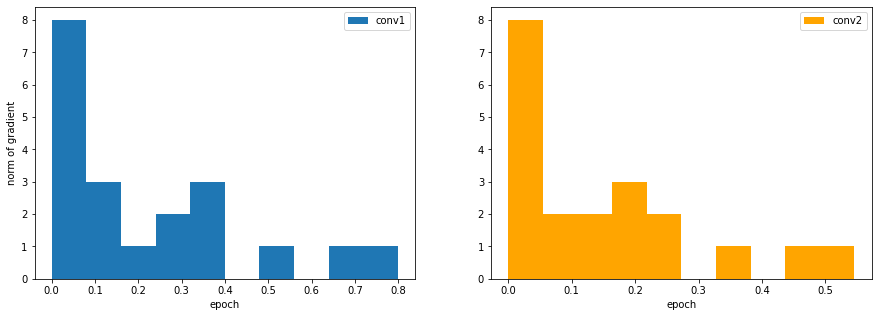

In [46]:
# plt.plot(conv1_grad,label='first layer')
# plt.plot(conv2_grad,label='second layer')
# plt.legend()
cnv1 = []
cnv2 = []
for i in range(len(conv1_grad_rmsprop)):
  cnv1.append(conv1_grad_rmsprop[i].cpu())
  cnv2.append(conv2_grad_rmsprop[i].cpu())

plt.figure(figsize=(15,5))
plt.title("norm of the gradients")

plt.subplot(121)
plt.hist(cnv1,label='conv1')
plt.legend()
plt.xlabel("epoch")
plt.ylabel("norm of gradient")

plt.subplot(122)
plt.hist(cnv2,label='conv2',color='orange')
plt.legend()
plt.xlabel("epoch")
#plt.ylabel("norm of gradient")

In [48]:
confuseMtx = np.zeros((numClass,numClass),dtype=int)    # Create empty confusion matrix
model.eval()
with torch.no_grad():
    permute = torch.randperm(nTest)                     # Shuffle test data
    testX = testX[permute,:,:,:]
    testY = testY[permute]
    for j in range(testBats):                           # Iterate over test batches
        batX = testX[j*batchSize:(j+1)*batchSize,:,:,:].to(dev)
        batY = testY[j*batchSize:(j+1)*batchSize].to(dev)
        yOut = model(batX)                              # Pass test batch through model
        pred = yOut.max(1,keepdim=True)[1]              # Generate predictions by finding the max Y values
        for j in torch.cat((batY.view_as(pred), pred),dim=1).tolist(): # Glue together Actual and Predicted to
            confuseMtx[j[0],j[1]] += 1                  # make (row, col) pairs, and increment confusion matrix
correct = sum([confuseMtx[i,i] for i in range(numClass)])   # Sum over diagonal elements to count correct predictions
print("Correct predictions: ",correct,"of",nTest)
print("accuracy :",(correct/nTest)*100," %")
print("Confusion Matrix:")
print(confuseMtx)
print(classNames)


Correct predictions:  5715 of 5740
accuracy : 99.56445993031359  %
Confusion Matrix:
[[971   0   1   0   0   0]
 [  0 984   0   0   4  15]
 [  3   0 982   0   0   0]
 [  0   0   0 865   0   0]
 [  0   1   0   0 937   1]
 [  0   0   0   0   0 976]]
['ChestCT', 'Hand', 'AbdomenCT', 'BreastMRI', 'CXR', 'HeadCT']


So, in RMSProp we ensured update in all the directions or parameters (both sparse and non-sparse). That's why we can clearly see that it's converging way fatser than others and the accuracy is also pretty good.

## **training and results using Adam optimizer :::**
It does everything that RMSProp do to solve the denominator decay problem of AdaGrad. In addition to that, use a cumulative history of gradients.

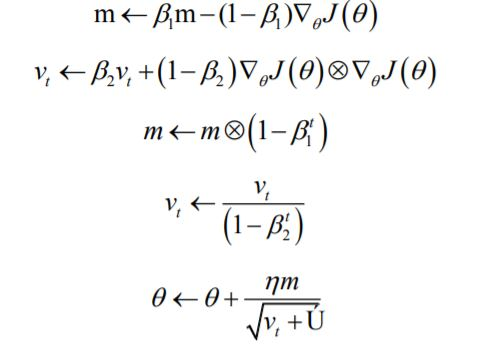



**learning rate = 0.001**

In [50]:
learnRate = 0.001          # Define a learning rate.
maxEpochs = 20            # Maximum training epochs
t2vRatio = 1.2            # Maximum allowed ratio of validation to training loss
t2vEpochs = 3             # Number of consecutive epochs before halting if validation loss exceeds above limit
batchSize = 300           # Batch size. Going too large will cause an out-of-memory error.
trainBats = nTrain // batchSize       # Number of training batches per epoch. Round down to simplify last batch
validBats = nValid // batchSize       # Validation batches. Round down
testBats = -(-nTest // batchSize)     # Testing batches. Round up to include all
CEweights = torch.zeros(numClass)     # This takes into account the imbalanced dataset.
for i in trainY.tolist():             #      By making rarer images count more to the loss, 
    CEweights[i].add_(1)              #      we prevent the model from ignoring them.
CEweights = 1. / CEweights.clamp_(min=1.)                     # Weights should be inversely related to count
CEweights = (CEweights * numClass / CEweights.sum()).to(dev)  # The weights average to 1
opti = om.Adam(model.parameters(), lr = learnRate)   # Initialize an optimizer

train_loss_list_adam = []
valid_loss_list_adam = []

conv1_grad_adam=[]
conv2_grad_adam=[]

for i in range(maxEpochs):
    model.train()                     # Set model to training mode
    epochLoss = 0.
    permute = torch.randperm(nTrain)  # Shuffle data to randomize batches
    trainX = trainX[permute,:,:,:]
    trainY = trainY[permute]
    for j in range(trainBats):        # Iterate over batches
        opti.zero_grad()              # Zero out gradient accumulated in optimizer
        batX = trainX[j*batchSize:(j+1)*batchSize,:,:,:].to(dev)   # Slice shuffled data into batches
        batY = trainY[j*batchSize:(j+1)*batchSize].to(dev)         # .to(dev) moves these batches to the GPU
        yOut = model(batX)            # Evalute predictions
        loss = F.cross_entropy(yOut, batY,weight=CEweights)        # Compute loss
        epochLoss += loss.item()      # Add loss
        loss.backward()               # Backpropagate loss
        opti.step()                   # Update model weights using optimizer
    validLoss = 0.
    permute = torch.randperm(nValid)  # We go through the exact same steps, without backprop / optimization
    validX = validX[permute,:,:,:]    # in order to evaluate the validation loss
    validY = validY[permute]
    model.eval()                      # Set model to evaluation mode
    with torch.no_grad():             # Temporarily turn off gradient descent
        for j in range(validBats):
            #opti.zero_grad()
            batX = validX[j*batchSize:(j+1)*batchSize,:,:,:].to(dev)
            batY = validY[j*batchSize:(j+1)*batchSize].to(dev)
            yOut = model(batX)
            validLoss += F.cross_entropy(yOut, batY,weight=CEweights).item()
    epochLoss /= trainBats            # Average loss over batches and print
    validLoss /= validBats

    train_loss_list_adam.append(epochLoss)
    valid_loss_list_adam.append(validLoss)
    print("Epoch = {:-3}; Training loss = {:.4f}; Validation loss = {:.4f}".format(i,epochLoss,validLoss))

    conv1_grad_adam.append(torch.linalg.norm(model.cnv1.weight.grad))
    conv2_grad_adam.append(torch.linalg.norm(model.cnv2.weight.grad))
    print("conv1 grads",torch.linalg.norm(model.cnv1.weight.grad)) 
    print("conv2 grads",torch.linalg.norm(model.cnv2.weight.grad))
    print("\n")
    # if validLoss > t2vRatio * epochLoss:
    #     t2vEpochs -= 1                # Test if validation loss exceeds halting threshold
    #     if t2vEpochs < 1:
    #         print("Validation loss too high; halting to prevent overfitting")
    #         break
    

Epoch =   0; Training loss = 0.0030; Validation loss = 0.0211
conv1 grads tensor(0.0025, device='cuda:0')
conv2 grads tensor(0.0010, device='cuda:0')


Epoch =   1; Training loss = 0.0025; Validation loss = 0.0209
conv1 grads tensor(0.3199, device='cuda:0')
conv2 grads tensor(0.1420, device='cuda:0')


Epoch =   2; Training loss = 0.0047; Validation loss = 0.0057
conv1 grads tensor(0.0005, device='cuda:0')
conv2 grads tensor(0.0001, device='cuda:0')


Epoch =   3; Training loss = 0.0018; Validation loss = 0.0101
conv1 grads tensor(0.0009, device='cuda:0')
conv2 grads tensor(0.0003, device='cuda:0')


Epoch =   4; Training loss = 0.0000; Validation loss = 0.0094
conv1 grads tensor(5.4941e-05, device='cuda:0')
conv2 grads tensor(1.7249e-05, device='cuda:0')


Epoch =   5; Training loss = 0.0000; Validation loss = 0.0091
conv1 grads tensor(1.7326e-05, device='cuda:0')
conv2 grads tensor(8.6115e-06, device='cuda:0')


Epoch =   6; Training loss = 0.0000; Validation loss = 0.0093
conv1 grad

**results :::**

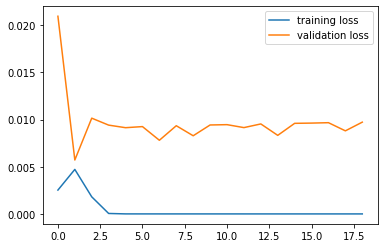

In [51]:
import matplotlib.pyplot as plt
plt.plot(train_loss_list_adam[1:],label='training loss')
plt.plot(valid_loss_list_adam[1:],label='validation loss')
plt.legend()

It looks like the accumulated history of gradients have made the process the fastest among the all the previous algorithms.

Text(0.5, 0, 'epoch')

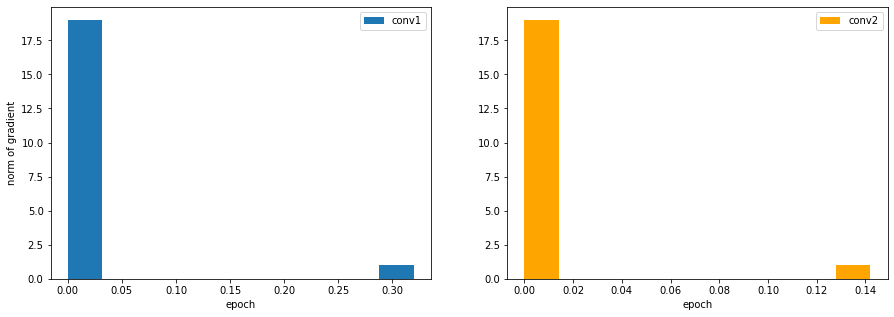

In [52]:
# plt.plot(conv1_grad,label='first layer')
# plt.plot(conv2_grad,label='second layer')
# plt.legend()
cnv1 = []
cnv2 = []
for i in range(len(conv1_grad_adam)):
  cnv1.append(conv1_grad_adam[i].cpu())
  cnv2.append(conv2_grad_adam[i].cpu())

plt.figure(figsize=(15,5))
plt.title("norm of the gradients")

plt.subplot(121)
plt.hist(cnv1,label='conv1')
plt.legend()
plt.xlabel("epoch")
plt.ylabel("norm of gradient")

plt.subplot(122)
plt.hist(cnv2,label='conv2',color='orange')
plt.legend()
plt.xlabel("epoch")
#plt.ylabel("norm of gradient")

And again it's bang on!!! in approx 95% cases the norm of the gradients are zero. Let's check the accuracy.

In [53]:
confuseMtx = np.zeros((numClass,numClass),dtype=int)    # Create empty confusion matrix
model.eval()
with torch.no_grad():
    permute = torch.randperm(nTest)                     # Shuffle test data
    testX = testX[permute,:,:,:]
    testY = testY[permute]
    for j in range(testBats):                           # Iterate over test batches
        batX = testX[j*batchSize:(j+1)*batchSize,:,:,:].to(dev)
        batY = testY[j*batchSize:(j+1)*batchSize].to(dev)
        yOut = model(batX)                              # Pass test batch through model
        pred = yOut.max(1,keepdim=True)[1]              # Generate predictions by finding the max Y values
        for j in torch.cat((batY.view_as(pred), pred),dim=1).tolist(): # Glue together Actual and Predicted to
            confuseMtx[j[0],j[1]] += 1                  # make (row, col) pairs, and increment confusion matrix
correct = sum([confuseMtx[i,i] for i in range(numClass)])   # Sum over diagonal elements to count correct predictions
print("Correct predictions: ",correct,"of",nTest)
print("accuracy :",(correct/nTest)*100," %")
print("Confusion Matrix:")
print(confuseMtx)
print(classNames)


Correct predictions:  5734 of 5740
accuracy : 99.89547038327527  %
Confusion Matrix:
[[ 972    0    0    0    0    0]
 [   0 1001    0    0    1    1]
 [   1    0  984    0    0    0]
 [   0    1    0  864    0    0]
 [   0    2    0    0  937    0]
 [   0    0    0    0    0  976]]
['ChestCT', 'Hand', 'AbdomenCT', 'BreastMRI', 'CXR', 'HeadCT']


In terms of accuracy also it has achieved the highest mark. So undoubtebly, for this kind of tasks ADAM optimizer is the ideal one to do your job.